BESP

23  04 19

Bimodal cell cycle and size related genes

Alex Casar / David Goode

****

**Cluster genes and cells by distribution classification**

**Estimate Silhouette coeficient for each cluster**

## Prepare

We allways need this chunck to use R in colab and mount google drive into the sesion

To use R magic in python colab. In 2023 the new rpy2 package was not able to run magic R, using a lower version soved the problem

In [2]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318081 sha256=27b1af0e345a1612254e60ff998424e6567633ca283f1b9dfe4c5fce19ba583e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [3]:
# activate R magic
%load_ext rpy2.ipython
# Load drive to use our files
from google.colab import drive
drive.mount('/content/drive')   # Change path

Mounted at /content/drive


## Reload packages and call libraries

We will always use this chunk to call our libraries

In [4]:
# Copy packages file to use it
%cp /content/drive/MyDrive/MELBOURNEbimodal/LIBRARIES/library13.tar.gz .
!tar xf /content/library13.tar.gz 
!rm /content/library13.tar.gz
%R .libPaths('/content/usr/local/lib/R/site-library')   # Change the library used by R binaries


'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


In [5]:
%%R
# Libraries
library(dplyr)  # Object management
library(Seurat)   # Single cell analysis
library(patchwork)  # Plots suplements
library(Matrix)   # To work/preview sparse matrix; Seurat is capable to.
library(vioplot) # Violin pots
library(ggplot2)  # Plots
#library(tidyverse)  # Data mining


library(Rcpp)   # It makes very simple to connect C++ to R
library(magrittr)   # Decrease development time and improve readability and maintainability of code
#library(clustree)   # Visualise Clusterings at Different Resolutions.

library(BiocParallel)   # Parallel evaluation
library(BiocParallel)   # Parallel evaluation
library(scShapes)   # A Statistical Framework for Modeling and Identifying Differential Distributions in Single-cell RNA-sequencing Data


library(BimodalIndex)
#library(SeuratData)   # mechanism for distributing datasets in the form of Seurat objects using R's internal package and data management 
                        #systems. It represents an easy way for users to get access to datasets that are used in the Seurat vignettes.


install.packages("DescTools")
library(DescTools)  

library(pheatmap)   # heatmap + clustering plot

library(viridis)  # Kiut ggplot colors
library(reshape)  # To convert matrix to long format required for ggplot

library(iZID)   # New KS-Test

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union





    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    





Attaching package: ‘zoo’



    as.Date, as.Date.numeric


(as ‘lib’ is unspecified)







	‘/tmp/RtmpuBsxHQ/downloaded_packages’


Attaching package: ‘reshape’



    expand



    rename




## Old new

Here we define what type of data we were going to use

At the end we were more interested in the new data since it had different stages of diasease

In [ ]:
%%R
OLDnew = "OLD"

In [6]:
%%R
OLDnew = "NEW"

## Definitions

In [7]:
%%R
# Parameters
MAX0 <- 0.10  # Keep genes with a certain number (perc.zero percent) of nonzero entries

# Directories
DATAdir <- "/content/drive/MyDrive/MELBOURNEbimodal/DATAinput/"   # Input files
TEMPdir <- "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/"  # Output temporal files
FINALdir <- "/content/drive/MyDrive/MELBOURNEbimodal/FINALdata/"  # Output of relevant files
IMAGEdir <- "/content/drive/MyDrive/MELBOURNEbimodal/IMAGESout" # Image files





# Statements
set.seed(0xBEEF)
setwd(DATAdir)


# Useful function
`%ni%` <- Negate(`%in%`)

In [8]:
%%R
# Samples metadata: We have two kinds of data: Old data and New data
SAMPLESclass <- list()
SAMPLESclass[["NEW"]] <- data.frame(row.names = c("T0", "M15", "M05", "M02", "M10", "M11", "M07", "M12", "M09"), 
                                    TYPE = c("Baseline", "Vehicle", "Vehicle", "Mid Disease", "Mid Disease", "End Disease", "End Disease", "Post Disease", "Post Disease"),
                                    DAY = c(0, NA, NA, 2,2,5,5,7,7))

SAMPLESclass[["OLD"]] <- data.frame(row.names = c("T0", "M8", "M10"), TYPE = c("Vitro", "Vivo", "Vivo"))



Formating list of genes (20 lists based on G2M and Size-related genes)

Probided by Alex on Feb 23, 2023

In [9]:
%%R
FILE = readLines(paste(DATAdir, "genes_per_mouse_per_goal.txt", sep = ""))
GENESnewLists <- list()
for (LINE in FILE){
    if (grepl("=", LINE, fixed = TRUE)){
        
        LINE <- sub("= \\[", "<- c(", LINE)
        LINE <- sub("]", ")", LINE)
        print(LINE)
        GENESnewLists[[strsplit(LINE, " ")[[1]][1]]] <- eval(parse(text=LINE))
    }
}

[1] "g2m_d0p1 <- c('G2e3', 'Orc6', 'Calm2', 'Jpt1', 'Rnf214', 'Cbx5', 'Cdc20', 'Hells', 'Cenpf', 'Kif4', 'Atad2', 'Arhgap4', 'Ccne1', 'Psen1', 'Tubb5', 'Hmgb2', 'Arl6ip1', 'Kpna2', 'Hinfp', 'Ccne2', 'Plk1', 'Rpa2', 'Ccnb1', 'Rnf7', 'Ndc80', 'Rfc3', 'Top2a', 'Smc2', 'Kif11', 'Slbp', 'Cenpa', 'Cdk1', 'Cdca8', 'Kif20b', 'Birc5', 'Uhrf1', 'Sapcd2', 'Cdca3', 'Ube2s', 'Cdca7', 'Cenpl', 'Spc25', 'Mis18bp1', 'Depdc1a', 'Mcm3', 'Srp54a', 'Ppm1g', 'Mki67', 'Bub3', 'Aurka', 'Ubb', 'Tubb4b', 'Nme7', 'Atp11c', 'Cdkn2d', 'Malat1', 'Ube2c', 'Tpx2', 'Sgo2a', 'Prc1', 'Hist1h1b', 'Hmmr', 'Rangap1', 'Kif23', 'Parpbp', 'Cenpe', 'Cks2', 'Tuba1c', 'Ctcf', 'Pcna', 'Ckap2l', 'Cd47', 'Smc1a', 'Kifc1', 'Ung', 'Smc4', 'Aurkb', 'Nusap1')"
[1] "g2m_d0p2 <- c('G2e3', 'Orc6', 'Calm2', 'Jpt1', 'Cbx5', 'Cdc20', 'Hells', 'Cenpf', 'Pomgnt1', 'Nasp', 'Atad2', 'Ccne1', 'H2afx', 'Tubb5', 'Hmgb2', 'Arl6ip1', 'Kpna2', 'Cenpc1', 'Ccne2', 'Plk1', 'Rpa2', 'Ccnb1', 'Ogfod1', 'Ndc80', 'AI314180', 'Rfc3', 'Top2a', 'Smc2', 'Kif11',

In [10]:
%%R
# Relevant genes: First list
Sgenes <- c("Mcm5","Pcna","Tyms","Fen1","Mcm2","Mcm4","Rrm1","Ung","Gins2","Mcm6","Cdca7","Dtl","Prim1","Uhrf1","Mlf1ip","Hells","Rfc2","Rpa2","Nasp","Rad51ap1","Gmnn","Wdr76","Slbp","Ccne2","Ubr7","Pold3","Msh2","Atad2","Rad51","Rrm2","Cdc45","Cdc6","Exo1","Tipin","Dscc1","Blm","Casp8ap2","Usp1","Clspn","Pola1","Chaf1b","Brip1","E2f8")
G2Mgenes <- c("Hmgb2","Cdk1","Nusap1","Ube2c","Birc5","Tpx2","Top2a","Ndc80","Cks2","Nuf2","Cks1b","Mki67","Tmpo","Cenpf","Tacc3","Fam64a","Smc4","Ccnb2","Ckap2l","Ckap2","AurkB","Bub1","Kif11","Anp32e","Tubb4b","Gtse1","Kif20b","Hjurp","Cdca3","Hn1","Cdc20","Ttk","Cdc25c","Kif2c","Rangap1","Ncapd2","Dlgap5","Cdca2","Cdca8","Ect2","Kif23","Hmmr","Aurka","Psrc1","Anln","Lbr","Ckap5","Cenpe","Ctcf","Nek2","G2e3","Gas2l3","Cbx5","Cenpa")
GENES <- list(S = Sgenes, G2M = G2Mgenes)

# Ad it to the list of lists
GENESnewLists[["SvsG2M"]] <- unlist(GENES)

## Read data

In [ ]:
%%R
# We need the counts and the metadata classification. That is available in the Seurat objects
SEUR <- readRDS(paste(DATAdir, OLDnew, "-BESP-CleanNorm3000-AllSamSeu.Rds", sep = ""))
# We need the annotation for the genes
TABLEannot <- read.table(paste(FINALdir, "FinalClassificationTable-All.tab", sep = ""), header = T)

# Clustering

## Clustering functions

Functions that are going to be used to cluster our data

Function to transform the matrix expression to express or not express genes (binary data)

In [ ]:
%%R
# We are going to use Binary gene expression
BINformatEXP <- function(SEURnorm, GENES){
    SEURnorm <- SEURnorm@assays$RNA@counts
    BINmat <- list()   # To save the binary matrix; Expressed/Not expressed
    # Relevant genes. We selected such genes before
    GENESi <- GENES[GENES %in% row.names(SEURnorm)]

    # Get binary matrix of cell cycle genes
    BINmat <- SEURnorm
    BINmat <- BINmat[GENESi, ]
    BINmat[BINmat != 0] <- 1  # Here we transform the table to a binary. All genes expressed are 1, the unexpressed genes are 0
    BINmat <- t(BINmat)   # We are going to cluster by samples (rows)

    gc()
    return(BINmat)
}


Clustering function for Alex's lists with all samples

In [ ]:
%%R
# Clustering for two cell types one sample at time
HIERclust_2cells_anyAnnot <- function(BINmat, SEURan, ANNOT, SAMP, MAIN = "All genes", CLASS = c("Distribution"), CLUSTERINGmet = c("ward.D")){
    # Colors for inside the heatmap: only two, expressed or not expressed
    ANNinn <- c("#BFFF00", "#193157")
    # Available colors for ouside the heatmap (cell type, sample, type of gene)
    COLORS <- c("#E11A29", "#98FB98", "#9B59B6", "#4600ff", "#009d85", "#f200ff", "#ff7200", "#0cff00", "#008cff")
    # Get anotation of cells: to label each row in heatmap
    P <- as.vector(SEURan@meta.data$Phase)
    P[P != "G2M"] <- "NoG2M"  # For this heatmap we only are interested to know if the cells is in G2M or not
    ANNOTcells <- data.frame(row.names = row.names(SEURan@meta.data), PHASE = P)


    # Get annotation of genes and colors
    GENESorder <- ANNOT$Gene
    ANNOTgenes <-  data.frame(ANNOT[ , CLASS])  # To label each column on heatmap
    colnames(ANNOTgenes) <- CLASS
    row.names(ANNOTgenes) <- GENESorder
    fCOL <- function(x){C <- COLORS[1:length(unique(x))]; names(C) <- unique(x); return(C)}
    fCOL1 <- function(x){C <- COLORS[1:length(unique(x))]; names(C) <- unique(x); return(list(C))}
    COLS <- apply(ANNOTgenes, 2, fCOL)
    if (length(CLASS) == 1){COLS <- apply(ANNOTgenes, 2, fCOL1)}
    
    if (length(CLASS) == 1){
        COLS[[1]] <- COLS[[1]][[1]]
    }
    # Final object for colors (we gather genes, distributions, expression,...)
    ANNout <- c(list(PHASE = c(NoG2M = "#FFFF00", G2M = "#0303B5")), COLS)
    print("Clustering")
    DISTANCE <- list()
    # This function performs a hierarchical cluster analysis using a set of dissimilarities for the objects being clustered. 
    # Initially, each object is assigned to its own cluster and then the algorithm proceeds iteratively, 
    # at each stage joining the two most similar clusters, continuing until there is just a single cluster. 
    # At each stage distances between clusters are recomputed by the Lance--Williams dissimilarity update formula according to 
    # the particular clustering method being used.
    HIERclus <- pheatmap(BINmat, clustering_method = CLUSTERINGmet, color = ANNinn, annotation_colors = ANNout, 
                                  main = paste(SAMPLE, MAIN, CLUSTERINGmet), 
                                  cluster_rows = TRUE, clustering_distance_rows = "binary", show_rownames = F, annotation_row = ANNOTcells, 
                                  cluster_cols = TRUE, clustering_distance_cols = "binary", show_colnames = T, annotation_col = ANNOTgenes)        
    gc()
    DISTANCE[["CELLS"]] <- as.matrix(dist(BINmat, method = "binary")); gc()
    DISTANCE[["GENES"]] <- as.matrix(dist(t(BINmat), method = "binary")); gc()


  gc()
  return(list(Clustering = HIERclus, Annotation = list(CELLS = ANNOTcells, GENES = ANNOTgenes)))
}


## Cophenetic distance function

In [ ]:
%%R
# Get cophenetic distance between cases
DISTANCEall <- function(CLUSTERING, ANNOTATION, FEATURE = c("GENES", "CELLS"), ANNOTlabels = c("Distribution", "Phase")){
    # Here we are gong to save our cophenetic distance
    COMPARISONS <- list()
    # First, we extract the cophenetic distance from our clustering. pheatmap estimates the dendogram for us. It is in tree_row and tree_row
    # We just need to transform it into a distance matrix with cophenetic()
    COPHdis <- list()
    # We have a different dendogram for Cells than for Genes
    COPHdis[["CELLS"]] <- as.matrix(cophenetic(CLUSTERING$tree_row)); gc()
    COPHdis[["GENES"]] <- as.matrix(cophenetic(CLUSTERING$tree_col)); gc()

    # Different dendograms for cells and genes, but the same process, thats wy we repeat it for genes and cells
    # For each feauture (genes or cells), we have a different set of groups (Phase, Distribution)
    for (i in 1:length(FEATURE)){  
        TYPE <- FEATURE[i]; ANNOTerm <- ANNOTlabels[i]
        COMPARISONS[[TYPE]] <- list()
        # Which comparisons are we going to make. Eg. G2M vs NoG2M cells
        COM <- expand.grid(unique(ANNOTATION[[TYPE]][, ANNOTerm]), unique(ANNOTATION[[TYPE]][, ANNOTerm]))
        # Is the same to compare A vs B than B vs A
        COM <- COM[!duplicated(t(apply(COM, 1, sort))), ]

        LABELSinterest <- ANNOTATION[[TYPE]][, ANNOTerm]   # We select just the label per cell/gene for the type and feature of interest
        names(LABELSinterest) <- row.names(ANNOTATION[[TYPE]])
        for (i in 1:nrow(COM)){   # For each comparison between groups
            GROUP1 <- as.character(COM[i, 1]) 
            GROUP2 <- as.character(COM[i, 2])
            # We get the names of the cells/genes that belong to group1 and group2
            FEATURES1 <- names(LABELSinterest[LABELSinterest == GROUP1])
            FEATURES2 <- names(LABELSinterest[LABELSinterest == GROUP2])
            # Extract the mean of all cophenetic distances of cells/genes belonging to group 1 vs cell/genes that belong to group 2
            COMPARISONS[[TYPE]][[paste(GROUP1, GROUP2, sep = "vs")]] <- COPHdis[[TYPE]][FEATURES1, FEATURES2]
        }
    }
    return(COMPARISONS)
}

## Silhouette coficient function

In [ ]:
%%R
fSILHOUETTE <- function(COPHmean, FEATURES = c("CELLS", "GENES")){
    SIL <- list()
    for (TYPE in FEATURES){  # For type of feature (gene or cells)
        SIL[[TYPE]] <- list()   # For each group, we will estimate the silhouette coeficient, so we create a list
        GROUP <- unique(unlist(strsplit(names(COPHmean[[TYPE]]), split = "vs"))) # To know the possible groups

        for (GROUP1 in GROUP){  # We will estimate the SC for each group
            # We will find the matrices with the group 1
            GROUP2 <- c()
            for (NAMES in names(COPHmean[[TYPE]])){
                NAME <- strsplit(NAMES, split = "vs")[[1]]
                if (NAME[1] == NAME[2]){next}   # We skip the simetrical matrices. Group1 vs Group2
                # Either if is "group1 vs other" or "other vs group1", we save the mean to select the lower 
                # Overall, we need to select the closest gene, we need to select it from all comparisons that of group1 vs others
                if (NAME[1] == GROUP1 | NAME[2] == GROUP1){
                    GROUP2[NAMES] <- mean(COPHmean[[TYPE]][[NAMES]])
                }
            }
            # Extract the name of the comparision of group1 vs other that contains the lower distance
            GROUP2v <- min(GROUP2)
            GROUP2 <- names(GROUP2)[which(GROUP2v %in% GROUP2)]
            # If is group1 vs other, the rows have the group 1 features (the ones of interest), otherwise, we use the cols have the features of interest
            if (strsplit(GROUP2, split = "vs")[[1]][1] == GROUP1){ROWcol <- 1}else{ROWcol <- 2}
            # We gather the mean distances of all genes/cells belonging to the same cluster in column #1
            # And the mean distances of all genes/cells of the sluter of interest (group1) againts the closest cluster (group2) in column #2
            # We put that in a dataframe to make easier the process of rest and selecting the maximum value
            MEANdis <- cbind(apply(COPHmean[[TYPE]][[GROUP2]], ROWcol, mean), apply(COPHmean[[TYPE]][[paste(GROUP1, GROUP1, sep = "vs")]], 1, mean))
            RES <- apply(MEANdis, 1, function (x) as.numeric(x[1]) - as.numeric(x[2]))   # Rest of group2 - group1
            MAX <- apply(MEANdis, 1, max)   # Select  the max value for the division
            SIL[[TYPE]][[GROUP1]] <- RES / MAX
        }
    }
    return(SIL)
}       

## Running the heatmap and retrieving the distance for used for the heatmap.

We are interested to know if selecting the amount of genes (by selecting just bimodal genes or ZIM genes) show a better clustering across cells


## Which clustering has a better performance?

We use the Silhouette coficient to score the succes of clustering by gene type and cell cell cycle stage

First we estimate the cophenetic distance. This is branch distance in the clustering (in the dendogram)

Then, we use the Silhouette coefficient to see how likely is to cluster cells/genes of the same type closer and far away

### All genes classified either with scShapes or the bimodality function

[1] "M15"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.4573063

$CELLS$G2M
[1] 0.8631287


[1] "M02"
[1] "Clustering"
$CELLS
$CELLS$G2M
[1] 0.7196785

$CELLS$NoG2M
[1] 0.2971999


[1] "M12"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.3871608

$CELLS$G2M
[1] 0.8075952




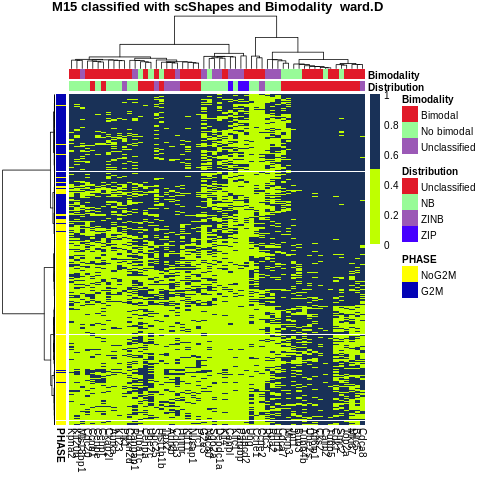

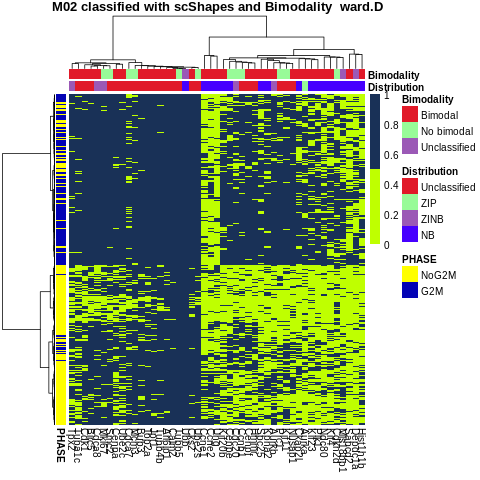

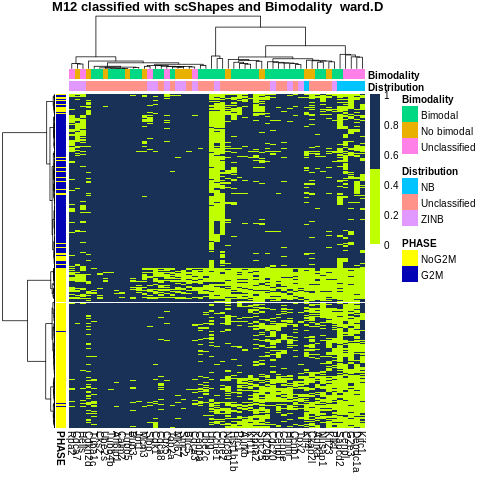

In [ ]:
%%R
SILHOUETTEc <- list()
HEATMAPS <- list()
for (LISTS in names(GENESnewLists)[1]){   # For each gene list
    SILHOUETTEc[[LISTS]] <- list()
    HEATMAPS[[LISTS]] <- list()
    for (SAMPLE in names(SEUR)[c(2,4,8)]){   # For each sample                            
        print(SAMPLE)
        # We filter the annotation table. Correct dataset, sample, gene list, AND SCSHAPES AS NOT UNCLASSIFIED
        TABLEannotB <- TABLEannot[TABLEannot$Dataset == OLDnew & TABLEannot$Sample == SAMPLE & TABLEannot$List == LISTS, ]
        TABLEannotB <- TABLEannotB[rowSums(is.na(TABLEannotB)) != ncol(TABLEannotB), ]
        # We transform the count matrix into a binary matrix 
        # We just want to know if the gene is expressed or not
        BIN <- BINformatEXP(SEUR[[SAMPLE]], TABLEannotB$Gene)
        # Rename NA to avoid problems in future
        TABLEannotB[is.na(TABLEannotB)] <- "Unclassified"
        # The real clustering function
        HEAT <- HIERclust_2cells_anyAnnot(BIN, SEUR[[SAMPLE]], TABLEannotB, SAMPLE, CLASS = c("Distribution", "Bimodality"), MAIN = "classified with scShapes and Bimodality ")
        # Estimate cophenetic distance between all groups of PHASE in CELLS. We get a list of distance matrices comparing all groups vs each other
        COPH <- DISTANCEall(HEAT[[1]], HEAT[[2]], FEATURE = c("CELLS", "GENES"), ANNOTlabels = c("PHASE", "Bimodality"))
        # Estimate the silhouette coeficient for all features. We get a list of silhouette coefiecients separated by feature type (cell/genes) and groups
        SILH <- fSILHOUETTE(COPH, "CELLS")
        SILH <- lapply(SILH, function(x) lapply(x, mean))
        print(SILH)
        SILHOUETTEc[[LISTS]][[SAMPLE]] <- SILH
        HEATMAPS[[LISTS]][[SAMPLE]] <- HEAT
    }
}
saveRDS(SILHOUETTEc, paste(FINALdir, "MeanSILHOUETTEcells-ALLists-scBimodalityClassGenes", OLDnew, ".Rds", sep = ""))
saveRDS(SILHOUETTEc, paste(FINALdir, "HEATMAPannot-ALLists-scBimodalityClassGenes", OLDnew, ".Rds", sep = ""))

### Just the bimodal genes (bimodality function)

[1] "M15"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.1801986

$CELLS$G2M
[1] 0.7593327


[1] "M02"
[1] "Clustering"
$CELLS
$CELLS$G2M
[1] 0.496659

$CELLS$NoG2M
[1] 0.3915873


[1] "M12"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.07848335

$CELLS$G2M
[1] 0.6445243




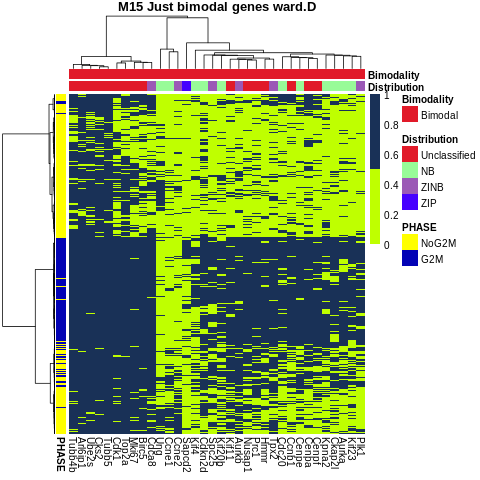

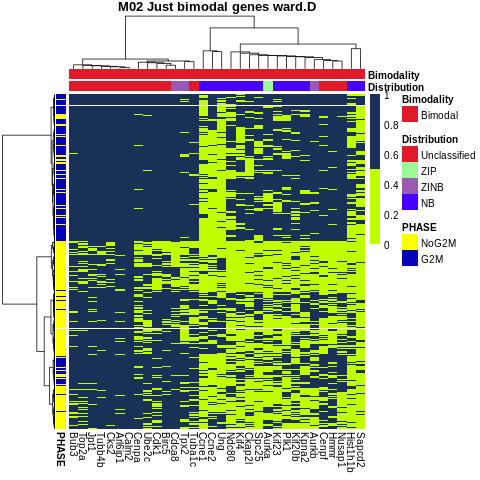

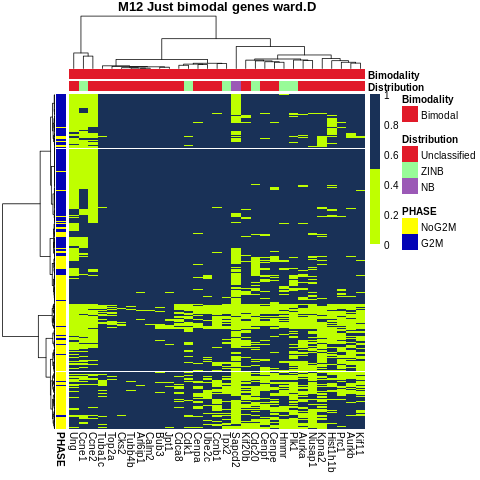

In [ ]:
%%R
SILHOUETTEc <- list()
HEATMAPS <- list()
for (LISTS in names(GENESnewLists)[1]){   # For each gene list
    SILHOUETTEc[[LISTS]] <- list()
    HEATMAPS[[LISTS]] <- list()
    for (SAMPLE in names(SEUR)[c(2,4,8)]){   # For each sample                            
        print(SAMPLE)
        # We filter the annotation table. Correct dataset, sample, gene list, AND SCSHAPES AS NOT UNCLASSIFIED
        TABLEannotB <- TABLEannot[TABLEannot$Dataset == OLDnew & TABLEannot$Sample == SAMPLE & TABLEannot$List == LISTS & TABLEannot$Bimodality == "Bimodal", ]
        TABLEannotB <- TABLEannotB[rowSums(is.na(TABLEannotB)) != ncol(TABLEannotB), ]
        # We transform the count matrix into a binary matrix 
        # We just want to know if the gene is expressed or not
        BIN <- BINformatEXP(SEUR[[SAMPLE]], TABLEannotB$Gene)
        # Rename NA to avoid problems in future
        TABLEannotB[is.na(TABLEannotB)] <- "Unclassified"
        # The real clustering function
        HEAT <- HIERclust_2cells_anyAnnot(BIN, SEUR[[SAMPLE]], TABLEannotB, SAMPLE, CLASS = c("Distribution", "Bimodality"), MAIN = "Just bimodal genes")
        # Estimate cophenetic distance between all groups of PHASE in CELLS. We get a list of distance matrices comparing all groups vs each other
        COPH <- DISTANCEall(HEAT[[1]], HEAT[[2]], FEATURE = c("CELLS"), ANNOTlabels = c("PHASE"))
        # Estimate the silhouette coeficient for all features. We get a list of silhouette coefiecients separated by feature type (cell/genes) and groups
        SILH <- fSILHOUETTE(COPH, "CELLS")
        SILH <- lapply(SILH, function (x) lapply(x, mean))
        print(SILH)
        SILHOUETTEc[[LISTS]][[SAMPLE]] <- SILH
        HEATMAPS[[LISTS]][[SAMPLE]] <- HEAT
    }
}
saveRDS(SILHOUETTEc, paste(FINALdir, "MeanSILHOUETTEcells-ALLists-BimodalGenes", OLDnew, ".Rds", sep = ""))
saveRDS(SILHOUETTEc, paste(FINALdir, "HEATMAPannot-ALLists-BimodalGenes", OLDnew, ".Rds", sep = ""))

### Just the classified genes with scShapes

[1] "M15"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.449155

$CELLS$G2M
[1] 0.8389775


[1] "M02"
[1] "Clustering"
$CELLS
$CELLS$G2M
[1] 0.608882

$CELLS$NoG2M
[1] -0.01829432


[1] "M12"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.04400286

$CELLS$G2M
[1] 0.7402602




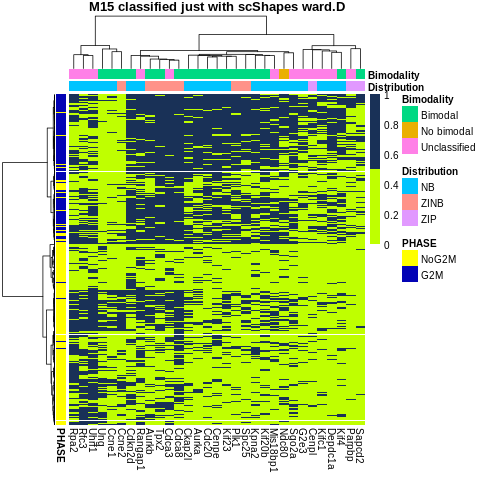

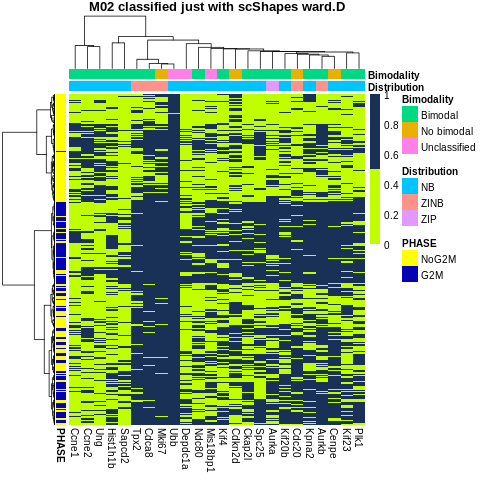

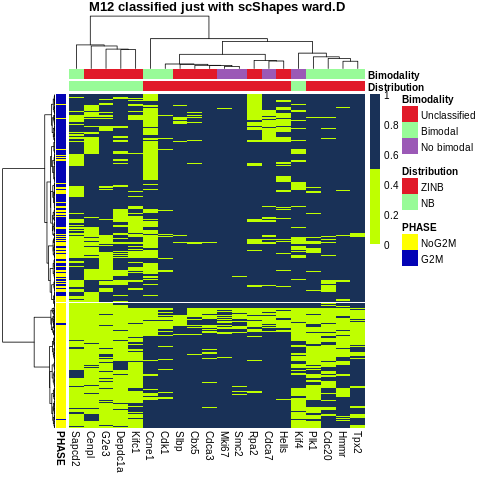

In [ ]:
%%R
SILHOUETTEc <- list()
HEATMAPS <- list()
for (LISTS in names(GENESnewLists)[1]){   # For each gene list
    SILHOUETTEc[[LISTS]] <- list()
    HEATMAPS[[LISTS]] <- list()
    for (SAMPLE in names(SEUR)[c(2,4,8)]){   # For each sample                            
        print(SAMPLE)
        # Rename NA to avoid problems in future
        TABLEannot[is.na(TABLEannot)] <- "Unclassified"
        TABLEannotB <- TABLEannot
        
        # We filter the annotation table. Correct dataset, sample, gene list, AND SCSHAPES AS NOT UNCLASSIFIED
        TABLEannotB <- TABLEannotB[TABLEannotB$Dataset == OLDnew & TABLEannotB$Sample == SAMPLE & TABLEannotB$List == LISTS & TABLEannotB$Distribution != "Unclassified", ]
        TABLEannotB <- TABLEannotB[rowSums(is.na(TABLEannotB)) != ncol(TABLEannotB), ]
        # We transform the count matrix into a binary matrix 
        # We just want to know if the gene is expressed or not
        BIN <- BINformatEXP(SEUR[[SAMPLE]], TABLEannotB$Gene)
        
        # The real clustering function
        HEAT <- HIERclust_2cells_anyAnnot(BIN, SEUR[[SAMPLE]], TABLEannotB, SAMPLE, CLASS = c("Distribution", "Bimodality"), MAIN = "classified just with scShapes")
        # Estimate cophenetic distance between all groups of PHASE in CELLS. We get a list of distance matrices comparing all groups vs each other
        COPH <- DISTANCEall(HEAT[[1]], HEAT[[2]], FEATURE = c("CELLS"), ANNOTlabels = c("PHASE"))
        # Estimate the silhouette coeficient for all features. We get a list of silhouette coefiecients separated by feature type (cell/genes) and groups
        SILH <- fSILHOUETTE(COPH, "CELLS")
        SILH <- lapply(SILH, function (x) lapply(x, mean))
        print(SILH)
        SILHOUETTEc[[LISTS]][[SAMPLE]] <- SILH
        HEATMAPS[[LISTS]][[SAMPLE]] <- HEAT
    }
}
saveRDS(SILHOUETTEc, paste(FINALdir, "MeanSILHOUETTEcells-ALLists-scClassGenes", OLDnew, ".Rds", sep = ""))
saveRDS(SILHOUETTEc, paste(FINALdir, "HEATMAPannot-ALLists-scClassGenes", OLDnew, ".Rds", sep = ""))

[1] "M15"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] 0.4069056

$CELLS$G2M
[1] 0.8010419


[1] "M02"
[1] "Clustering"
$CELLS
$CELLS$G2M
[1] 0.549352

$CELLS$NoG2M
[1] 0.2182691


[1] "M12"
[1] "Clustering"
$CELLS
$CELLS$NoG2M
[1] -0.2512399

$CELLS$G2M
[1] 0.4855484




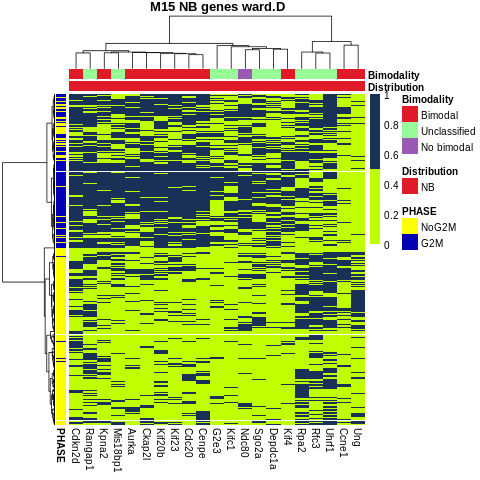

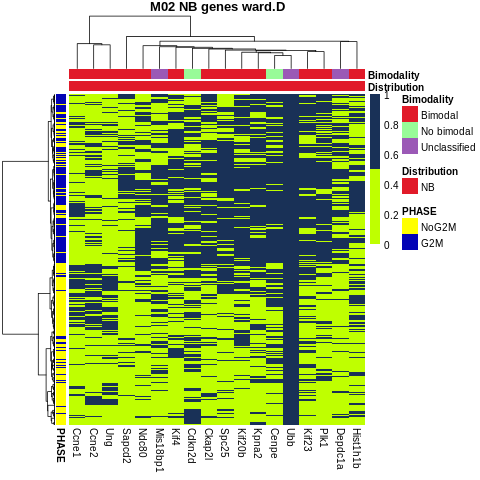

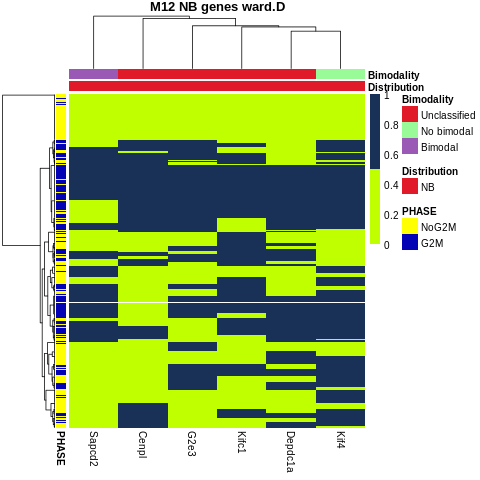

In [ ]:
%%R
SILHOUETTEc <- list()
HEATMAPS <- list()
for (LISTS in names(GENESnewLists)[1]){   # For each gene list
    SILHOUETTEc[[LISTS]] <- list()
    HEATMAPS[[LISTS]] <- list()
    for (SAMPLE in names(SEUR)[c(2,4,8)]){   # For each sample                            
        print(SAMPLE)
        # Rename NA to avoid problems in future
        TABLEannot[is.na(TABLEannot)] <- "Unclassified"
        TABLEannotB <- TABLEannot
        
        # We filter the annotation table. Correct dataset, sample, gene list, AND SCSHAPES AS NOT UNCLASSIFIED
        TABLEannotB <- TABLEannotB[TABLEannotB$Dataset == OLDnew & TABLEannotB$Sample == SAMPLE & TABLEannotB$List == LISTS & TABLEannotB$Distribution == "NB", ]
        TABLEannotB <- TABLEannotB[rowSums(is.na(TABLEannotB)) != ncol(TABLEannotB), ]
        # We transform the count matrix into a binary matrix 
        # We just want to know if the gene is expressed or not
        BIN <- BINformatEXP(SEUR[[SAMPLE]], TABLEannotB$Gene)
        
        # The real clustering function
        HEAT <- HIERclust_2cells_anyAnnot(BIN, SEUR[[SAMPLE]], TABLEannotB, SAMPLE, CLASS = c("Distribution", "Bimodality"), MAIN = "NB genes")
        # Estimate cophenetic distance between all groups of PHASE in CELLS. We get a list of distance matrices comparing all groups vs each other
        COPH <- DISTANCEall(HEAT[[1]], HEAT[[2]], FEATURE = c("CELLS"), ANNOTlabels = c("PHASE"))
        # Estimate the silhouette coeficient for all features. We get a list of silhouette coefiecients separated by feature type (cell/genes) and groups
        SILH <- fSILHOUETTE(COPH, "CELLS")
        SILH <- lapply(SILH, function (x) lapply(x, mean))
        print(SILH)
        SILHOUETTEc[[LISTS]][[SAMPLE]] <- SILH
        HEATMAPS[[LISTS]][[SAMPLE]] <- HEAT
    }
}
saveRDS(SILHOUETTEc, paste(FINALdir, "MeanSILHOUETTEcells-ALLists-nbClassGenes", OLDnew, ".Rds", sep = ""))
saveRDS(SILHOUETTEc, paste(FINALdir, "HEATMAPannot-ALLists-nbClassGenes", OLDnew, ".Rds", sep = ""))

### All genes for each list

In [ ]:
%%R
SILHOUETTEc <- list()
HEATMAPS <- list()
for (LISTS in names(GENESnewLists)[1]){   # For each gene list
    SILHOUETTEc[[LISTS]] <- list()
    HEATMAPS[[LISTS]] <- list()
    for (SAMPLE in names(SEUR)[4]){   # For each sample                            
        print(SAMPLE)
        TABLEannotB <- merge(TABLEannot, data.frame(Gene = GENESnewLists[[LISTS]]), all = TRUE, by = "Gene")
        # Rename NA to avoid problems in future
        TABLEannotB[is.na(TABLEannotB)] <- "Unclassified"
        # We filter the annotation table. Correct dataset, sample, gene list
        TABLEannotB <- TABLEannotB[TABLEannot$Dataset == OLDnew & TABLEannot$Sample == SAMPLE & TABLEannot$List == LISTS, ]
        TABLEannotB <- TABLEannotB[rowSums(is.na(TABLEannotB)) != ncol(TABLEannotB), ]
        # We transform the count matrix into a binary matrix 
        # We just want to know if the gene is expressed or not
        BIN <- BINformatEXP(SEUR[[SAMPLE]], TABLEannotB$Gene)
        
        # The real clustering function
        HEAT <- HIERclust_2cells_anyAnnot(BIN, SEUR[[SAMPLE]], TABLEannotB, SAMPLE, CLASS = c("Distribution", "Bimodality"))
        # Estimate cophenetic distance between all groups of PHASE in CELLS. We get a list of distance matrices comparing all groups vs each other
        COPH <- DISTANCEall(HEAT[[1]], HEAT[[2]], FEATURE = c("CELLS"), ANNOTlabels = c("PHASE"))
        # Estimate the silhouette coeficient for all features. We get a list of silhouette coefiecients separated by feature type (cell/genes) and groups
        SILH <- fSILHOUETTE(COPH, "CELLS")
        SILH <- lapply(SILH, function (x) lapply(x, mean))
        SILHOUETTEc[[LISTS]][[SAMPLE]] <- SILH
        HEATMAPS[[LISTS]][[SAMPLE]] <- HEAT
    }
}
saveRDS(SILHOUETTEc, paste(FINALdir, "MeanSILHOUETTEcells-ALLists-AllGenes", OLDnew, ".Rds"))
saveRDS(SILHOUETTEc, paste(FINALdir, "HEATMAPannot-ALLists-AllGenes", OLDnew, ".Rds"))

# Explore Silhouette coeficient

Put Silhouette values and metadata in 

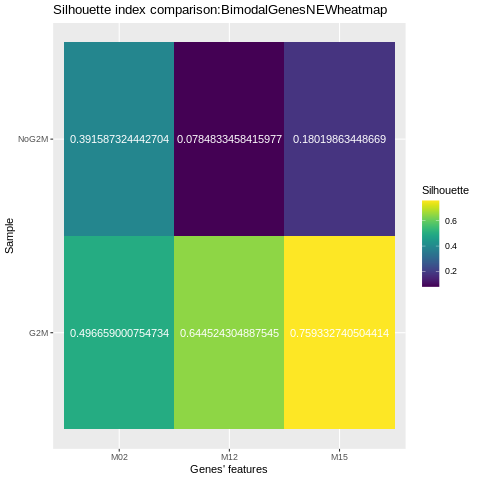

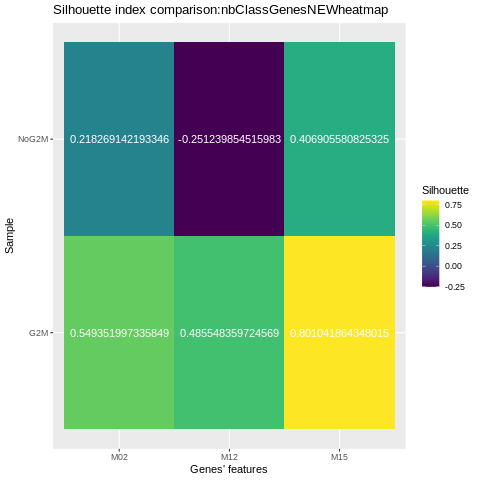

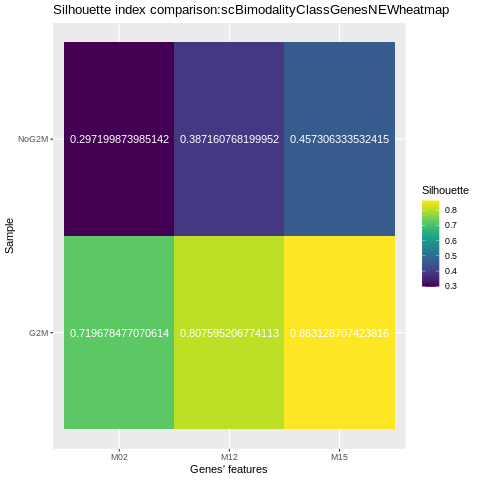

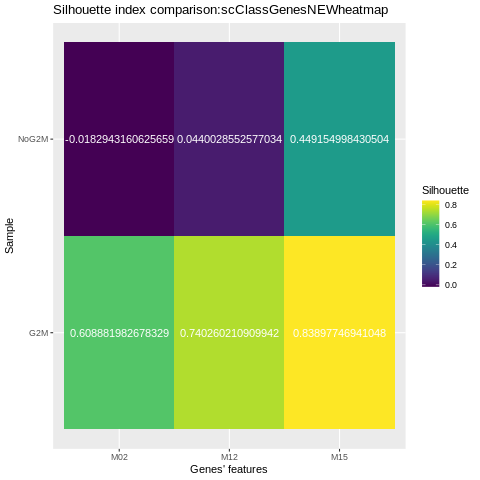

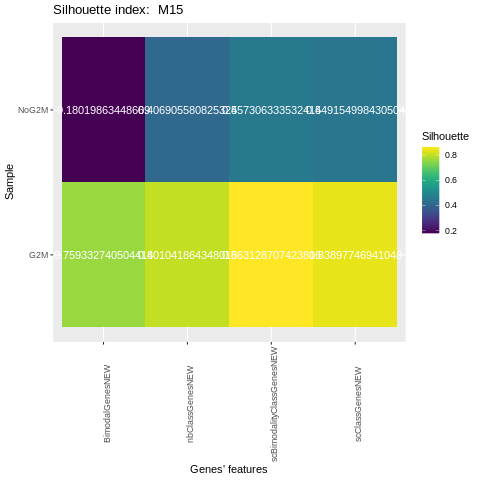

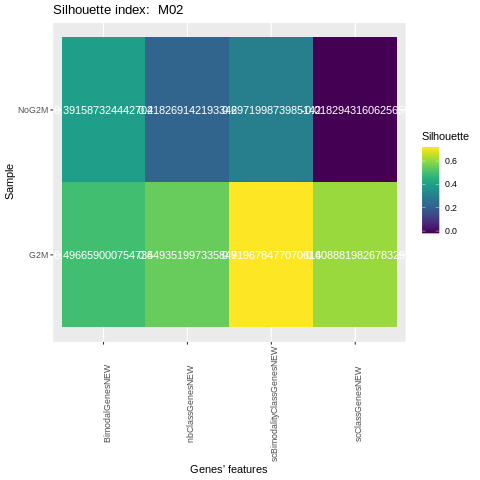

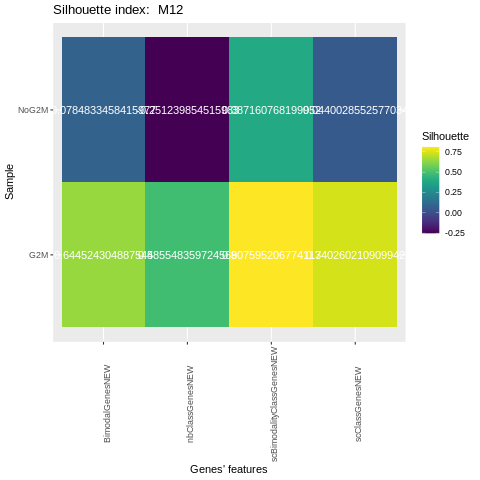

In [11]:
%%R
FILES <- list.files(path = FINALdir, pattern = "MeanSIL")  # For each sample, we have a file with all respetitions of the KS-Test
FILES
ALLsil <- data.frame()
for (FILE in paste(FINALdir, FILES, sep = "")){
    SILOUETTEc <- readRDS(FILE)
    # For better handeling, we put the silhouettes values in a vector format.
    # The names contain the metadata separatd by point. List, Sample, Type, Group
    SILall <- unlist(SILOUETTEc)

    COMP <- strsplit(strsplit(FILE, "-")[[1]][3], "[.]")[[1]][1]

    # Transform the names metadata into a dataframe
    SILHmat <- data.frame(do.call(rbind, strsplit(names(SILall), split = "[.]")))
    # Join metadata dataframe with silhouette values
    SILHmat <- cbind(SILHmat, SILall)
    SILHmat <- cbind(SILHmat, COMP)
    colnames(SILHmat) <- c("List", "Sample", "Type", "Group", "Silhouette")
    print(ggplot(SILHmat, aes(Sample, Group, fill= Silhouette)) + scale_fill_viridis() + geom_tile() + geom_text(aes(label = Silhouette), color = "white") + labs(title=paste("Silhouette index comparison:", COMP, "heatmap", sep = ""), x = "Genes' features", y = "Sample"))
    ALLsil <- rbind(ALLsil, SILHmat)
}

colnames(ALLsil) <- c("List", "Sample", "Type", "Group", "Silhouette", "Comparison")

for (SAMP in unique(ALLsil$Sample)){
    M <- ALLsil[ALLsil$Sample == SAMP, ]
    print(ggplot(M, aes(Comparison, Group, fill= Silhouette)) + scale_fill_viridis() + geom_tile() + geom_text(aes(label = Silhouette), color = "white") + labs(title=paste("Silhouette index: ", SAMP), x = "Genes' features", y = "Sample") + theme(axis.text.x = element_text(angle = 90)))
}
#ggplot(ALLsil, aes(Sample, Group, fill= Silhouette)) + scale_fill_viridis() + geom_tile() + geom_text(aes(label = Silhouette), color = "white") + labs(title=paste("Silhouette index for the old data"), x = "Genes' features", y = "Sample")
saveRDS(ALLsil, paste(FINALdir, "SilhouetteAll.Rds"))